This notebook will write a class that performs PCA and HMM on macro indicators (maybe will have two classes, one for PCA and one for HMM)

In [159]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches



In [160]:
class MacroPCA:
    def __init__(self, data, n_components = None, frequency='ME'):
        """
        Initialse the PCA wrapper.
        param: data - dataframe of macroeconomic indicators
        param: n_components - number of principal components to keep (default: all)
        param: frequency - resampling frequency ('ME' = monthly, 'QE' = quarterly, 'YE' = yearly)
        """
        self.original_data = data
        self.n_components = n_components
        self.frequency = frequency.upper()
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=self.n_components)
        self.fitted = False

    def standardise(self):
        if self.frequency not in ['ME', 'QE', 'YE']:
            raise ValueError("Frequency must be 'ME', 'QE', or 'YE'")
        self.data = self.original_data.resample(self.frequency).mean()

        self.data_scaled = self.scaler.fit_transform(self.data)
        return self.data_scaled
    
    def run_pca(self):
        if not hasattr(self, 'data_scaled'):
            raise ValueError("You must call standardize() before run_pca().")
        
        self.components = self.pca.fit_transform(self.data_scaled)
        self.explained_variance = self.pca.explained_variance_ratio_
        self.loadings = pd.DataFrame(self.pca.components_.T,
                                     index=self.data.columns,
                                     columns=[f'PC{i+1}' for i in range(self.pca.n_components_)])
        self.fitted = True
        return pd.DataFrame(self.components,
                             columns=self.loadings.columns,
                             index=self.data.index)
        
    def get_explained_variance(self):
        if not self.fitted:
            raise RuntimeError("PCA has not been run yet.")
        return self.explained_variance

    def get_loadings(self):
        if not self.fitted:
            raise RuntimeError("PCA has not been run yet.")
        return self.loadings




In [161]:
# Get the macro data
macro_df = pd.read_csv("monthly_macro.csv")
macro_df.set_index('Date', inplace=True)
macro_df.index = pd.to_datetime(macro_df.index)

macro_df = macro_df[macro_df.index >= '1990-01-01']


In [162]:
m_model = MacroPCA(data=macro_df, n_components=4)
m_model.standardise()
pc_df_m = m_model.run_pca()

# Optional:
print(m_model.get_explained_variance())
print(m_model.get_loadings())


[0.44346413 0.18114306 0.13684418 0.09245506]
                       PC1       PC2       PC3       PC4
VIX              -0.177389  0.535876 -0.244452  0.448400
2Y                0.458181  0.280575  0.140574  0.008471
10Y               0.370743  0.344026  0.430815 -0.017367
YieldCurve       -0.351235  0.033261  0.565788 -0.057706
CreditSpread     -0.400851  0.304392 -0.115394  0.204326
FedFundsRate      0.459148  0.270138  0.026473  0.026666
Inflation_YoY     0.143042 -0.339343  0.207414  0.867295
UnemploymentRate -0.307593  0.179755  0.571097 -0.019255
GDP_YoY           0.105900 -0.448954  0.177692  0.014249


Ideas for interpretations:
PC1 - Tight monetary conditions/poliy regime. 
PC2 - Risk Sentiment/Financial Stress
PC3 - Yield Curve Steepness + Labur Slack
PC4 - Inflation specific component

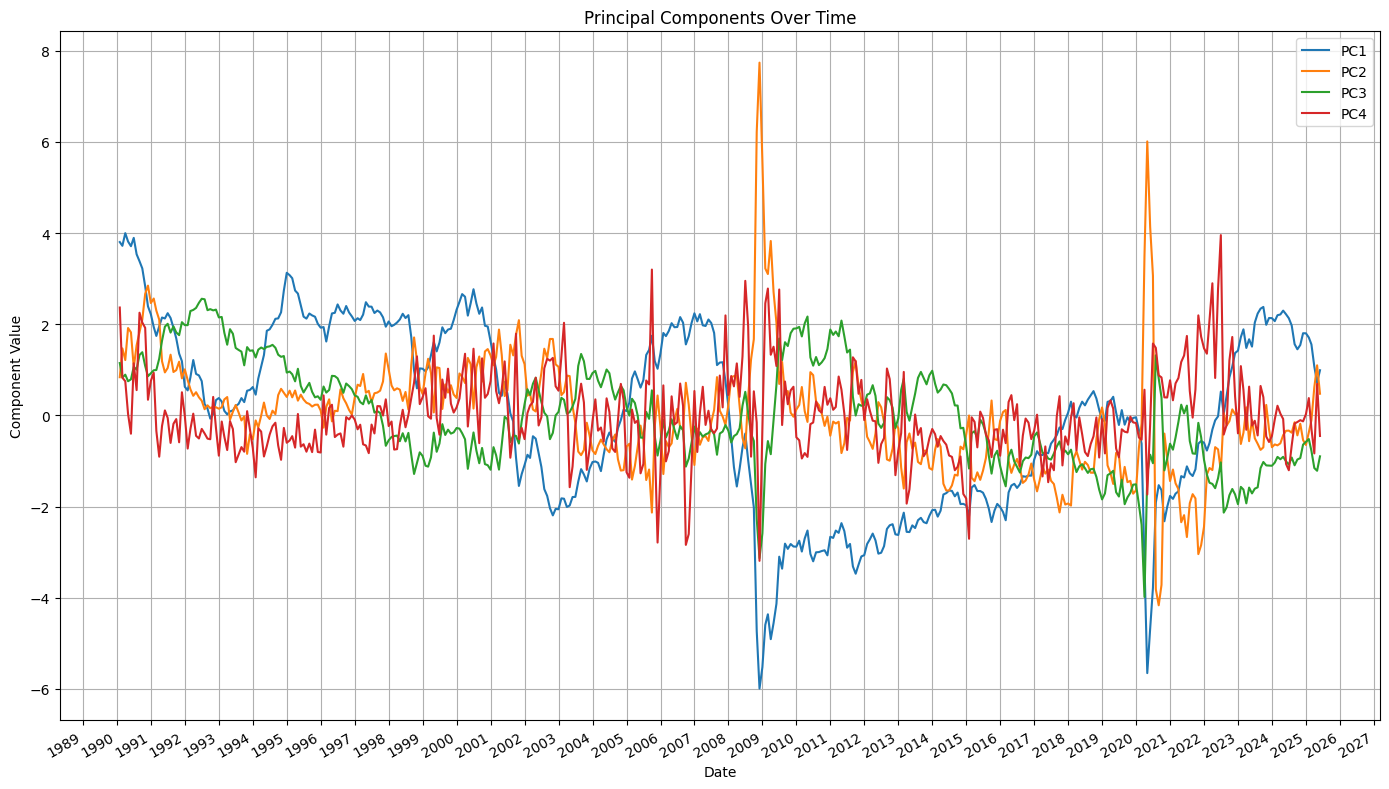

In [163]:
pc_df_m.index = pd.to_datetime(pc_df_m.index)

plt.figure(figsize=(14,8))
for i in range(4):
    plt.plot(pc_df_m.index, pc_df_m.iloc[:,i], label=f'PC{i+1}')
plt.title('Principal Components Over Time')
plt.xlabel('Date')
plt.ylabel('Component Value')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))  # Every 2 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for readability

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [164]:
from hmmlearn.hmm import GaussianHMM


Now, what if we look at it quarterly?

In [165]:
q_model = MacroPCA(data=macro_df, n_components=4, frequency='QE')
q_model.standardise()
pc_df_q = q_model.run_pca()

print(q_model.get_explained_variance())
print(q_model.get_loadings())


[0.44947535 0.18624591 0.13700203 0.08924214]
                       PC1       PC2       PC3       PC4
VIX              -0.183215  0.528194 -0.222504  0.588583
2Y                0.452212  0.286005  0.147383  0.031351
10Y               0.364874  0.341969  0.438169  0.011466
YieldCurve       -0.350944  0.014778  0.565484 -0.053851
CreditSpread     -0.403793  0.291526 -0.098508  0.281026
FedFundsRate      0.453903  0.277079  0.034350  0.043039
Inflation_YoY     0.172350 -0.358420  0.190973  0.636745
UnemploymentRate -0.307482  0.155662  0.578500 -0.032780
GDP_YoY           0.110977 -0.455627  0.187054  0.402751


now, if we look at it yearly?

In [166]:
y_model = MacroPCA(data=macro_df, n_components=4, frequency='YE')
y_model.standardise()
pc_df_y = y_model.run_pca()

print(y_model.get_explained_variance())
print(y_model.get_loadings())


[0.47433018 0.18408237 0.1374981  0.1000608 ]
                       PC1       PC2       PC3       PC4
VIX              -0.163101  0.548726 -0.275792  0.346789
2Y                0.437906  0.296700  0.143976 -0.064462
10Y               0.348573  0.379578  0.420239 -0.060937
YieldCurve       -0.354362  0.070083  0.544573  0.031495
CreditSpread     -0.415209  0.284711 -0.107924  0.036357
FedFundsRate      0.439879  0.289018  0.029935 -0.102808
Inflation_YoY     0.213817 -0.078535 -0.013349  0.900928
UnemploymentRate -0.310849  0.186155  0.551173  0.136886
GDP_YoY           0.162248 -0.506423  0.336949  0.169045


In [167]:
class RegimeHMM():
    def __init__(self, pca_output, n_regimes=4, n_iterations=10000, covariance_type="full"):
        """
        Initialise HMM model.
        param: pca_output - dataframe of the PCA output on macro indicators.
        param: n_regimes - number of latent regimes.
        param: n_iterations - maximum number of iterations to perform (default: 10000).
        param: covariance_type - {'spherical', 'diag', 'full', 'tied'} The type of covariance parameters to use:
                                    - spherical: each state uses a single variane value that applies to all features
                                    - diag: each state uses a diagonal covariance matrix
                                    - full: each state uses a full (i.e. unrestricted covariance matrix) (default)
                                    - tied: all mixture components of each state uses the same full covariance matrix

        """

        self.pca_output = pca_output
        self.n_regimes = n_regimes
        self.iterations = n_iterations
        self.covariance_type = covariance_type
        self.hmm_model = GaussianHMM(n_components=self.n_regimes, 
                                     covariance_type=self.covariance_type, 
                                    n_iter=self.iterations, 
                                    random_state=42)
        
    def fit(self):
        "Fit the HMM model to the PCA output."
        self.hmm_model.fit(self.pca_output)
        regime_labels = self.hmm_model.predict(self.pca_output) # Predict regime labels
        self.pca_output['Regime'] = regime_labels # Add regime labels to DataFrame
        return self.pca_output
    
    def get_transition_matrix(self):
        "Get the transition matrix of the HMM model."
        print("HMM Transition Matrix:")
        return print(np.round(self.hmm_model.transmat_, 3))
    
    def plot_pc_with_regimes(self, title):
        """
        Plot the principal components with shaded regimes.
        param: title - title of the plot.
        """
        plt.figure(figsize=(16, 7))
        regime_colors = plt.cm.Set1(np.arange(self.n_regimes))

        # Plot each principal component
        for i in range(1, self.n_regimes + 1):
            plt.plot(self.pca_output.index, self.pca_output[f'PC{i}'], label=f'PC{i}', linewidth=1)

        # Shade regimes
        prev_regime = self.pca_output['Regime'].iloc[0]
        start_date = self.pca_output.index[0]
        used_patches = {}

        for i in range(1, len(self.pca_output)):
            current_regime = self.pca_output['Regime'].iloc[i]
            if current_regime != prev_regime:
                color = regime_colors[prev_regime]
                plt.axvspan(start_date, self.pca_output.index[i], color=color, alpha=0.2)
                if prev_regime not in used_patches:
                    used_patches[prev_regime] = mpatches.Patch(color=color, label=f'Regime {prev_regime}')
                start_date = self.pca_output.index[i]
                prev_regime = current_regime

        # Final span
        color = regime_colors[prev_regime]
        plt.axvspan(start_date, self.pca_output.index[-1], color=color, alpha=0.2)
        if prev_regime not in used_patches:
            used_patches[prev_regime] = mpatches.Patch(color=color, label=f'Regime {prev_regime}')

        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Principal Component Value')
        plt.legend(handles=list(used_patches.values()))
        plt.grid(True)
        plt.tight_layout()

        plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.gcf().autofmt_xdate()

        pc_legend = plt.legend(loc='upper left')
        plt.gca().add_artist(pc_legend)  # Show both legends
        plt.legend(handles=list(used_patches.values()), loc='upper right', title='Regimes')

        plt.show()
        


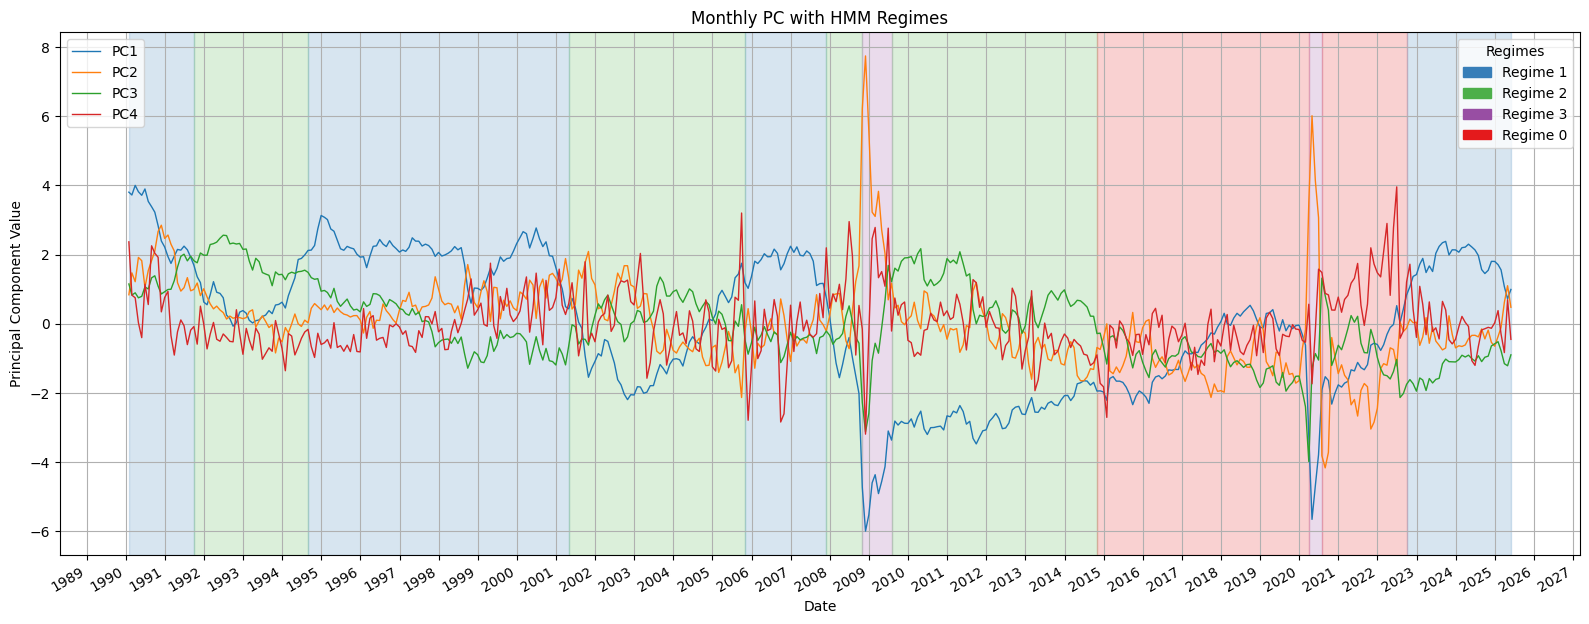

HMM Transition Matrix:
[[0.978 0.011 0.    0.011]
 [0.    0.981 0.019 0.   ]
 [0.006 0.012 0.975 0.006]
 [0.077 0.    0.077 0.846]]


In [168]:
m_hmm = RegimeHMM(pca_output=pc_df_m, n_regimes=4, covariance_type='full')
m_hmm.fit()
m_hmm.plot_pc_with_regimes("Monthly PC with HMM Regimes")
m_hmm.get_transition_matrix()

# q_hmm = RegimeHMM(pca_output=pc_df_q, n_regimes=4)
# q_hmm.fit()
# q_hmm.plot_pc_with_regimes("Quarterly PC with HMM Regimes")
# q_hmm.get_transition_matrix()

# y_hmm = RegimeHMM(pca_output=pc_df_y, n_regimes=4)
# y_hmm.fit()
# y_hmm.plot_pc_with_regimes("Yearly PC with HMM Regimes")
# y_hmm.get_transition_matrix()

This next section is about comparisons

In [169]:
# Explained variance for each fequency
m_ex_var = m_model.get_explained_variance()
q_ex_var = q_model.get_explained_variance()
y_ex_var = y_model.get_explained_variance()

explained_variance_df = pd.DataFrame({
    "Frequency": ['Monthly', 'Quarterly', 'Yearly'],
    'PC1' : [m_ex_var[0], q_ex_var[0], y_ex_var[0]],
    'PC2': [m_ex_var[1], q_ex_var[1], y_ex_var[1]],
    'PC3': [m_ex_var[2], q_ex_var[2], y_ex_var[2]],
    'PC4': [m_ex_var[3], q_ex_var[3], y_ex_var[3]],
    'Cumulative Variance': [m_ex_var.sum(), q_ex_var.sum(), y_ex_var.sum()]
    
})

explained_variance_df.set_index('Frequency', inplace=True)
explained_variance_df = explained_variance_df.round(3)
print(explained_variance_df)



             PC1    PC2    PC3    PC4  Cumulative Variance
Frequency                                                 
Monthly    0.443  0.181  0.137  0.092                0.854
Quarterly  0.449  0.186  0.137  0.089                0.862
Yearly     0.474  0.184  0.137  0.100                0.896


Compare regime interpretability

In [170]:
# Monthly

monthly_regime_means = pc_df_m.groupby('Regime')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
print("Monthly Regime Means:")
print(monthly_regime_means.round(3))

Monthly Regime Means:
          PC1    PC2    PC3    PC4
Regime                            
0      -0.856 -1.259 -0.945 -0.009
1       2.042  0.437 -0.199  0.004
2      -1.137 -0.038  0.815 -0.051
3      -4.561  3.987 -1.186  0.655


In [171]:
# # Quarterly
# quarterly_regime_means = pc_df_q.groupby('Regime')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
# print("Quarterly Regime Means:")
# print(quarterly_regime_means.round(3))

In [172]:
# # Yearly
# yearly_regime_means = pc_df_y.groupby('Regime')[['PC1', 'PC2', 'PC3', 'PC4']].mean()
# print("Yearly Regime Means:")
# print(yearly_regime_means.round(3))